In [ ]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Constrained Optimization By Linear Approximation (COBYLA) Algorithm

In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cobyla
from scipy import optimize
import pandas as pd
%matplotlib inline

In [3]:
def objective(x):
    return x[0]*x[1]

def constr1  (x):
    return 1 - (x[0]**2 + x[1]**2)

def constr2(x):
    return x[1]



Constrained Optimization By Linear Approximation (COBYLA) is a trusted region algorithm like Nelder-Mead that solves the  **constrained** problem
$$ \min F(\mathbf{x}) : \  \ c_i(\mathbf{x}) \ge 0 \ i=1,\ldots,m.$$
The basic idea of the algorithm is to use a simplex created from a starting guess of the minimizer, and either 
* improve the simplex by generating a new minimizer from an approximation problem that solves a linear approximation of the problem within a prespecified "trusted" area, or 
* update the simplex to satisfy acceptability conditions. 
<img src="cob_acc.png" style="float:right; margin:0px 15px 15px 0px; cursor:pointer; cursor:hand; border:0" width="150" height="150"/>

The algorithm thus has two branches we call $\star$ and $\Delta$ for generating a new minimizer and updating the simplex, respectively. 

A simplex is **acceptable** if $\sigma^j \ge \alpha \rho$ and $\eta^j \le \beta \rho$ for all $j=1,\ldots,n$, where $\alpha$ and $\beta$ are parameters satsifying $0 < \alpha < 1 < \beta$, $\sigma^j$ is the distance of vertex $j$ to the opposite face of the simplex, and $\eta^j$ is the length of the edge from $\mathbf{x}^0$ to $\mathbf{x}^j$.The parameter $\rho$ varies between two user-provided limits of $\rho_{beg}$ and $\rho_{end}$. These conditions are meant to prevent the simplex from being too flat, in which case it may affect the linear approximation (discussed below). The parameter $\mu$ is also adjusted during the algorithm. 

To compare solutions, the algorithm uses the following merit function:
$$\Phi(\mathbf{x}) = F(\mathbf{x}) + \mu \left [ \max\{-c_i(\mathbf{x}):  i=1,\ldots,m\} \right ]_+$$
where $[a]_+=\max\{a,0\}$. If all constraints are satisfied by a solution, then $\Phi(\mathbf{x})=F(\mathbf{x})$.

We generate the new minimizer $\mathbf{x}^\star$ by solving the linear approximation problem 
$$\min \hat{F}(\mathbf{x}) : \ \hat{c_i}(\mathbf{x}) \ge 0 \ \ i=1,\ldots,m, \ \ \|\mathbf{x}-\mathbf{x}^0\|_2 \le \rho,$$
where $\hat{F}(\mathbf{x})$ and $\hat{c_i}(\mathbf{x})$ are derived from interpolating $F(\mathbf{x})$ and $c_i(\mathbf{x})$ through the vertices of the simplex. Since the simplex has $n+1$ vertices, $\hat{F}(\mathbf{x})$ and each of the $\hat{c_i}(\mathbf{x})$  are defined by solving a system of linear equations. For example, $\hat{F}(\mathbf{x})= \mathbf{a} \mathbf{x} + a_0$ and the coeffients $a_i$ are the solutions to the system $\mathbf{a} \mathbf{x}^i + a_0 = F(\mathbf{x}^i)$ for $i=0,\dots,n$.  If there is more than one minimizer, we choose the one that minimizes $\|\mathbf{x}-\mathbf{x}^0\|_2$. In case the constraint system is inconsistent with $\|\mathbf{x}-\mathbf{x}^0\|_2 \le \rho$, we choose $x^\star$ as the minimizer of the constraint with the greatest violation subject to $\|\mathbf{x}-\mathbf{x}^0\|_2 \le \rho$, and then minimize $\hat{F}(\mathbf{x})$ if there is still room. 

The parameter $\mu$ is updated as follows. If $\bar{\mu}$ is the smallest nonnegative value of $\mu$, it yields $\Phi({\mathbf{x}^\star}) \le \Phi(\mathbf{x}^0)$. If $\mu > \frac{2}{3} \bar{\mu}$, it is large enough and we don't change it. Otherwise, we set $\mu= 2 \bar{\mu}$.

Finally, the $\Delta$ branch involves the generation of $\mathbf{x}^\Delta$, which is calculated as follows. If the acceptability condition on $\eta$ is violated, we calculate the minimum index $\ell$ that maximizes $\eta$. Otherwise we obtain $\ell$ as the index minimizing $\sigma$. Let $\mathbf{v}^\ell$ be the vector of unit length perpendicular to the face opposite to $\mathbf{x}^\ell$. Then: 
$$\mathbf{x}^\Delta = \mathbf{x}^0 \pm \gamma \rho \mathbf{v}^\ell$$
where $\gamma$ is in $(\alpha,1)$, set to $\frac{1}{2}$ in the `scipy` algorithm, and we choose the $\pm$ sign to minimize the merit function approximation $\hat{\Phi}(\mathbf{x}^\Delta)$.

The algorithm is as follows:

1. Set $n$, $m$, $\rho_{beg}$, $\rho_{end}$,  $\rho=\rho_{beg}$, $\mu=0$ and initial guess $\mathbf{x}^0$. Set branch to $\star$.
2. Create simplex with vertices $\mathbf{x}^0$ and $\mathbf{x}^i=\mathbf{x}^0+\mathbf{e}^i$ for $i=1,\ldots,n$ where $\mathbf{e}^i$ is the $i^\text{th}$ unit vector.  
3. Ensure $\mathbf{x}^0$ is the optimal vertex of the simplex and that the simplex is acceptable.
4. If branch is $\star$ or simplex is acceptable, go to Step 5; else, go to Step 13.
5. Generate $\mathbf{x}^\star$ by solving the linear programming approximation.
6. If $\mathbf{x}^\star$ distance from $\mathbf{x}^0$ is less than $\frac{1}{2} \rho$, go to Step 7; else, go to Step 8.
7. If the simplex is acceptable, go to Step 8; else, set branch to $\Delta$ and go to Step 3.
8. If $\rho \le \rho_{end}$, terminate; else, update $\rho$ and $\mu$ and go to Step 3.
9. If $\mu$ is large enough, go to Step 10; else, go to Step 12.
10. Evaluate $F$ and $c_i$ at $\mathbf{x}^\star$ and revise or change the simplex.
11. If improvement is less than $0.1$, go to Step 7; else, set branch to $\star$ and go to Step 3. 
12. Revise $\mu$. If $\mathbf{x}^0$ is the optimal vertex, go to Step 10; else, go to Step 3.
13. Calculate $\mathbf{x}^{\Delta}$, make it a vertex of the simplex, and set branch to $\star$. Go to Step 3.

For a detailed description of the algorithm, see "A Direct Search Optimization Method that Models the Objective and Constraint Functions By Linear Interpolation" by Powell.<sup>1</sup>

## Run COBYLA from `scipy`

We will use the Rosenbrock function as an objective function and add some constraints. The first constraint requires that $x_1^2 + x_2^2 \le 1$ and so it excludes the unconstrained optimum of `(1,1)`. Constraints need to be given in the $\ge$ form, so the above constraint is given as $1-(x_1^2+x_2^2) \ge 0$.

In [4]:
def objective(x):
    return 100*(x[1]-x[0]**2)**2+(1-x[0])**2

def constr1  (x):
    return 1 - (x[0]**2 + x[1]**2)

def constr2(x):
    return x[1]

The `scipy` algorithm provides the following parameters for tuning:
* `rhobeg` the starting value of $\rho$ defaulting to `1`
* `rhoend` the ending value of $\rho$ defaulting to `1e-4`
* `maxfun` the maximum number of function calls defaulting to `1000`
* `catol`  the tolerance for constaint feasibility defaulting to `0.0002`

The `qiskit` wrapper of the `scipy` algorithm uses two more parameters to control multistart trials and unbounded variables.

Below we call the function for various `rhoend` and `maxfun` values and we plot the results. We start with the unconstrained problem, and we find the optimal `(0.99894,0.99788)` after about `10,000` function calls for `rhoend` less than `1e-5`. Note that the algorithm doesn't find the optimal solution for the bigger value of `rhoend`.

In [5]:
rplt=[]
mplt=[]
nplt=[]
rho=[1e-3,1e-4,1e-5,1e-6,1e-7,1e-9,1e-12]
maxf=[100,250,500,750,1000,2500,5000,10000,15000]
for r in rho:
    for mx in maxf: 
        x,y=fmin_cobyla(objective, [0.5, 0.5],[], maxfun=mx, disp=0, rhoend=r)
        rplt.append(r)
        mplt.append(mx)
        nrm=np.linalg.norm(np.array([x,y]).reshape(2,1)-np.array([1,1]).reshape(2,1))
        nplt.append(nrm)
print(x,y)

0.9987724177477753 0.9975412793507518


In [6]:
df=pd.DataFrame()
df['rho']=np.array(rplt)
df['mxfun']=np.array(mplt)
df['acc']=np.array(nplt)

Text(0, 0.5, 'Accuracy (distance from optimum)')

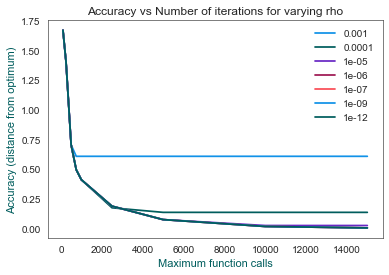

In [7]:
for r in rho:
    pdf=df[df['rho']==r]
    plt.plot(pdf.mxfun,pdf.acc,label=r)
plt.legend()
plt.title('Accuracy vs Number of iterations for varying rho')
plt.xlabel('Maximum function calls')
plt.ylabel('Accuracy (distance from optimum)')

Here we repeat the optimization, but we have added the first constraint. The optimum has changed to `(0.786414,0.617698)`. The algorithm finds this after around `2000` calls and for `rhoend` smaller than `1e-4`.

0.7864151541304203 0.6176983125717823


Text(0, 0.5, 'Accuracy (distance from optimum)')

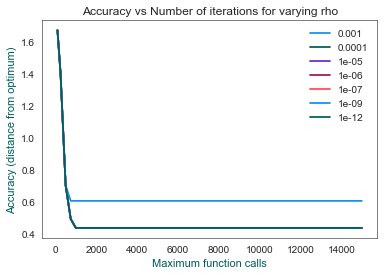

In [8]:
rplt=[]
mplt=[]
nplt=[]
rho=[1e-3,1e-4,1e-5,1e-6,1e-7,1e-9,1e-12]
maxf=[100,250,500,750,1000,2500,5000,10000,15000]
for r in rho:
    for mx in maxf: 
        x,y=fmin_cobyla(objective, [0.5, 0.5],[constr1], maxfun=mx, disp=0, rhoend=r)
        rplt.append(r)
        mplt.append(mx)
        nrm=np.linalg.norm(np.array([x,y]).reshape(2,1)-np.array([1,1]).reshape(2,1))
        nplt.append(nrm)
print(x,y)
df=pd.DataFrame()
df['rho']=np.array(rplt)
df['mxfun']=np.array(mplt)
df['acc']=np.array(nplt)
for r in rho:
    pdf=df[df['rho']==r]
    plt.plot(pdf.mxfun,pdf.acc,label=r)
plt.legend()
plt.title('Accuracy vs Number of iterations for varying rho')
plt.xlabel('Maximum function calls')
plt.ylabel('Accuracy (distance from optimum)')

## References

<a id='powell1992'></a>1. M. J. D. Powell, "A Direct Search Optimization Method that Models the Objective and Constraint Functions By Linear Interpolation", in S. Gomez and J-P. Hennart (eds.), *Advances in Optimization and Numerical Analysis*, pp 51-67. Kluwer Academic Publishers, 1994.

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>